In [9]:
pip install yfinance matplotlib


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [10]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Retrieve Real Market Data

In [11]:
# Select a stock symbol (e.g., Apple Inc.)
symbol = 'MSTR'
ticker = yf.Ticker(symbol)

# Get the current underlying asset price from historical data
S0 = ticker.history(period='1d')['Close'].iloc[-1]
print("Underlying Price (S0):", S0)

# Get available option expiration dates
expirations = ticker.options
print("Available expiration dates:", expirations)

# Choose the nearest expiration date (or change as needed)
selected_date = expirations[0]
print("Selected expiration date:", selected_date)
    
# Fetch the option chain for the selected date (we'll work with puts as an example)
option_chain = ticker.option_chain(selected_date)
puts = option_chain.puts

# Choose the put option with strike closest to the current underlying price
puts['diff'] = abs(puts['strike'] - S0)
target_put = puts.loc[puts['diff'].idxmin()]

K = target_put['strike']
implied_vol = target_put['impliedVolatility']  # Use the market-implied volatility if available
print("Selected Put Option Strike (K):", K)
print("Implied Volatility:", implied_vol)

Underlying Price (S0): 242.35060119628906
Available expiration dates: ('2025-03-14', '2025-03-21', '2025-03-28', '2025-04-04', '2025-04-11', '2025-04-17', '2025-04-25', '2025-05-16', '2025-06-20', '2025-07-18', '2025-09-19', '2025-10-17', '2025-12-19', '2026-01-16', '2026-06-18', '2026-12-18', '2027-01-15', '2027-06-17', '2027-12-17')
Selected expiration date: 2025-03-14
Selected Put Option Strike (K): 242.5
Implied Volatility: 1.0732468212890627


# Set Up Model Parameters

In [12]:
# Risk-free rate assumption (modify as needed)
r = 0.04

# Time to maturity (in years) computed from the selected expiration date
T = (pd.to_datetime(selected_date) - pd.Timestamp.today()).days / 365
print("Time to Maturity (T):", T)

# Simulation parameters
steps = 50              # number of time steps
dt = T / steps          # time step size
N = steps               # number of time steps
M = 50000               # number of Monte Carlo paths

# Use implied volatility from the option data if available, else default to 0.2
sigma = implied_vol if pd.notnull(implied_vol) else 0.2 

# Jump diffusion parameters (Merton's model)
lamb = 0.75       # jump intensity (jumps per year)
mu_j = -0.1       # mean jump size (in log space)
sigma_j = 0.3     # jump volatility

# Time grid for plotting
time_grid = np.linspace(0, T, N+1)

Time to Maturity (T): 0.005479452054794521


# Monte Carlo Simulation with Jump Diffusion Dynamics

In [13]:
# Initialize asset price paths
S = np.zeros((M, N+1))
S[:, 0] = S0

for t in range(1, N+1):
    # Diffusion component with drift adjustment for jumps
    z = np.random.normal(size=M)
    drift_adjustment = r - lamb * (np.exp(mu_j + 0.5 * sigma_j**2) - 1) - 0.5 * sigma**2
    drift_adjustment = drift_adjustment * dt
    diffusion = sigma * np.sqrt(dt) * z
    
    # Jump component: simulate number of jumps with a Poisson process
    num_jumps = np.random.poisson(lamb * dt, size=M)
    jump_component = np.zeros(M)
    jump_paths = num_jumps > 0
    if np.any(jump_paths):
        # For simplicity, assume one effective jump per time step if any jump occurs
        jump_component[jump_paths] = np.random.normal(mu_j, sigma_j, size=np.sum(jump_paths))
    
    # Update the asset price path
    S[:, t] = S[:, t-1] * np.exp(drift_adjustment + diffusion + jump_component)

# Option Pricing using the Longstaff-Schwartz Algorithm

In [14]:
# Define the payoff function for an American put option
def payoff(S):
    return np.maximum(K - S, 0)

# At maturity, the option payoff is known
cashflow = payoff(S[:, -1])

# Backward induction (skip t=0)
for t in range(N-1, 0, -1):
    # Identify in-the-money paths at time t
    itm = payoff(S[:, t]) > 0
    if np.sum(itm) == 0:
        continue

    # Extract asset prices and discount the cashflows one time step back
    St_itm = S[itm, t]
    Y = cashflow[itm] * np.exp(-r * dt)
    
    # Use a polynomial regression (constant, linear, quadratic) as basis functions
    A = np.vstack([np.ones_like(St_itm), St_itm, St_itm**2]).T
    coeffs, _, _, _ = np.linalg.lstsq(A, Y, rcond=None)
    
    # Estimate the continuation value
    continuation_value = coeffs[0] + coeffs[1] * St_itm + coeffs[2] * St_itm**2
    immediate_exercise = payoff(St_itm)
    
    # Early exercise decision: exercise if immediate payoff exceeds the continuation value
    exercise = immediate_exercise > continuation_value
    cashflow[itm] = np.where(exercise, immediate_exercise, cashflow[itm])

# Discount cash flows to time zero to get the option price
price = np.mean(cashflow * np.exp(-r * dt))
print("Simulated American put option price under jump diffusion: {:.4f}".format(price))

Simulated American put option price under jump diffusion: 7.7612


# Visualize a Few Simulated Asset Price Paths

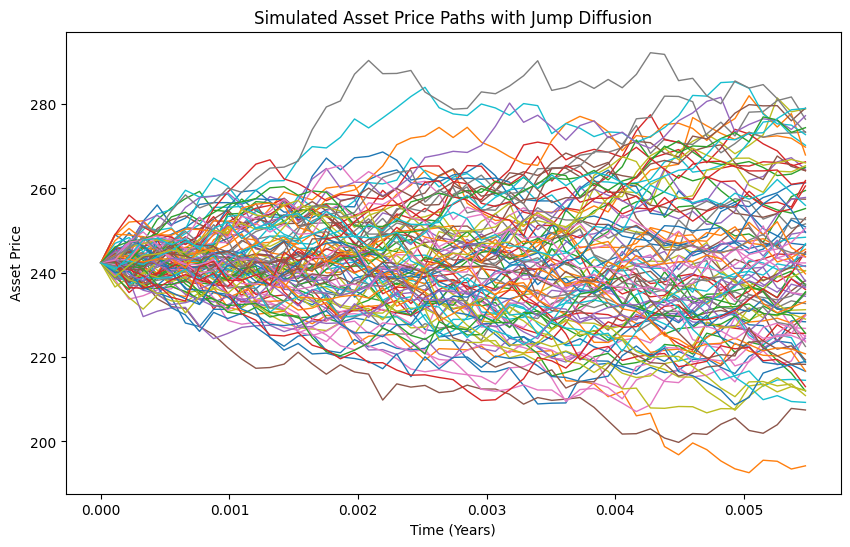

In [15]:
plt.figure(figsize=(10, 6))
for i in range(100):
    plt.plot(time_grid, S[i, :], lw=1)
plt.xlabel('Time (Years)')
plt.ylabel('Asset Price')
plt.title('Simulated Asset Price Paths with Jump Diffusion')
plt.show()